In [1]:
import logging
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.arg_extract import get_args
from utils.experiment_evaluator import evaluate_experiment
from utils.experiment import Experiment
from argparse import Namespace
from utils.experiment_evaluator import image_prepro, create_evaluation_dataloader, get_test_predictions_pairs, save_sequence_plots
import os
from utils.io import save
plt.ioff()
from utils.io import load
batch_images_all = load('batches.pickle')

data_directory = '/Users/stathis/Experiments/wave_propagation/'
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]

In [3]:
batch_images_all.keys()

dict_keys(['Test_1', 'Test_2', 'Test_3', 'Lines_1', 'Lines_2', 'Lines_3', 'Double_Drop_1', 'Double_Drop_2', 'Double_Drop_3', 'Illumination_135_1', 'Illumination_135_2', 'Illumination_135_3', 'Illumination_Random_1', 'Illumination_Random_2', 'Illumination_Random_3', 'Shallow_Depth_1', 'Shallow_Depth_2', 'Shallow_Depth_3', 'Smaller_Tub_1', 'Smaller_Tub_2', 'Smaller_Tub_3', 'Bigger_Tub_1', 'Bigger_Tub_2', 'Bigger_Tub_3', 'Fixed_Tub_1', 'Fixed_Tub_2', 'Fixed_Tub_3'])

In [86]:
exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3'
model_name = 'Causal\nLSTM-R'
test_set = 'Lines_1'

batch_images = batch_images_all[test_set]

# output_frames_int, target_frames = get_experiment_predictions(exp_name, batch_images, belated=False)
# output_frames_bel, target_frames = get_experiment_predictions(exp_name, batch_images, belated=True)

belated = True
dd = {'experiment_name': exp,
        'num_epochs': 1,
        'num_workers': 1,
        'test_starting_point': 15,
        'num_total_output_frames':80,
        'debug': False}

args_new = Namespace(**dd)
experiment = Experiment(args_new)
experiment.load_from_disk(test=True)

output_frames, target_frames = get_test_predictions_pairs(experiment.model, belated, 
                                                          batch_images, 
                                                          args_new.test_starting_point-experiment.args.num_input_frames, 
                                                          args_new.num_total_output_frames)
out_prepro = image_prepro(output_frames, experiment.normalizer), image_prepro(target_frames, experiment.normalizer)

# Viz latent space of PredRNN

In [87]:
model = experiment.model
params = model.state_dict()

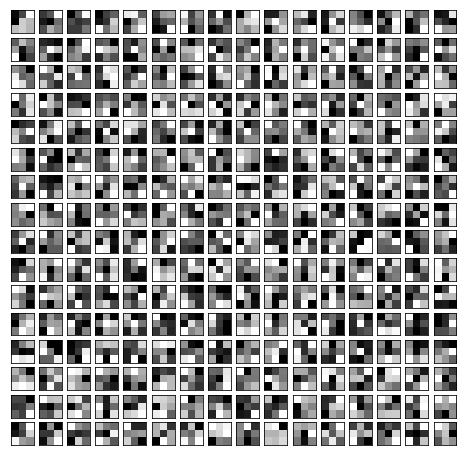

In [88]:
lines = 16
rows = 16

p0 = params['lstm.0.conv_c.weight']
fig, axarr = plt.subplots(lines, rows, figsize=(8, 8))

for i in range(lines):
    for k in range(rows):
        axarr[i, k].imshow(p0[i,k,:], cmap='gray')
        axarr[i, k].set_yticks([])
        axarr[i, k].set_xticks([])

plt.show()

In [89]:
import torch
starting_point = 0
num_total_output_frames = 3
model.eval()
num_input_frames = model.get_num_input_frames()
with torch.no_grad():
    input_end_point = starting_point + num_input_frames
    input_frames = batch_images[:1, starting_point:input_end_point, :, :].clone()
    output_frames = model.get_future_frames(input_frames, num_total_output_frames, belated)
    target_frames = batch_images[:1, input_end_point:(input_end_point + num_total_output_frames), :, :]

In [90]:
model

PredRNNPP(
  (lstm): ModuleList(
    (0): CausalLSTMCell(
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_c): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_x): Conv2d(8, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1_1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): CausalLSTMCell(
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_c): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_x): Conv2d(64, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1_1

In [91]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for i in range(4):
    model.lstm[i].conv_h.register_forward_hook(get_activation('lstm.%d.conv_h' %i))
    model.lstm[i].conv_c.register_forward_hook(get_activation('lstm.%d.conv_c' %i))
    model.lstm[i].conv_m.register_forward_hook(get_activation('lstm.%d.conv_m' %i))
    model.lstm[i].conv_x.register_forward_hook(get_activation('lstm.%d.conv_x' %i))
    model.lstm[i].conv_o.register_forward_hook(get_activation('lstm.%d.conv_o' %i))

output = model.get_future_frames(input_frames, 2, belated)

In [92]:
def print_activations(act_name):
    act = activation[act_name].squeeze()
    print(act.size())

    lines = 8
    rows = 8

    fig, axarr = plt.subplots(lines, rows, figsize=(8, 8))
    for i in range(lines):
        for k in range(rows):
            axarr[i, k].imshow(image_prepro(act[i+rows*k,:], experiment.normalizer), cmap='gray', vmin=0, vmax=1)
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])

    plt.show()

torch.Size([256, 31, 31])


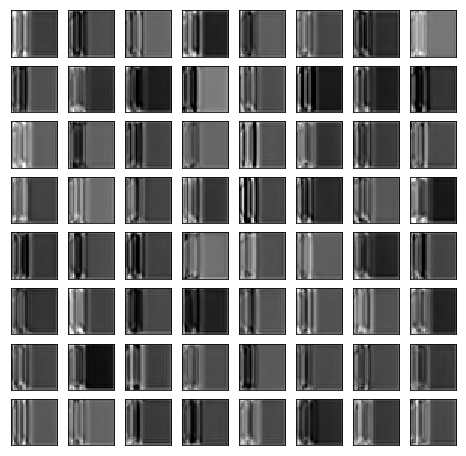

In [93]:
print_activations('lstm.0.conv_h')

torch.Size([256, 31, 31])


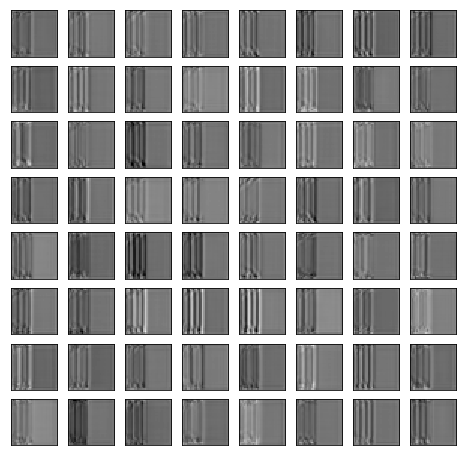

In [94]:
print_activations('lstm.1.conv_h')

torch.Size([256, 31, 31])


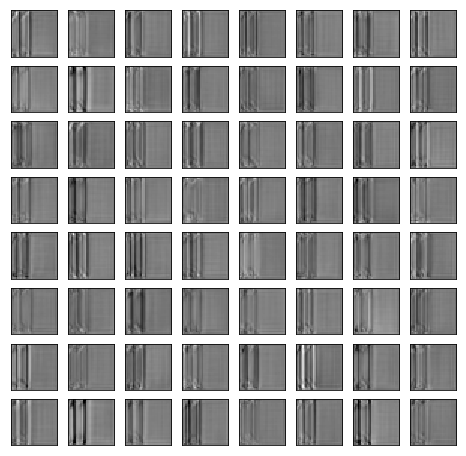

In [95]:
print_activations('lstm.2.conv_h')

torch.Size([256, 31, 31])


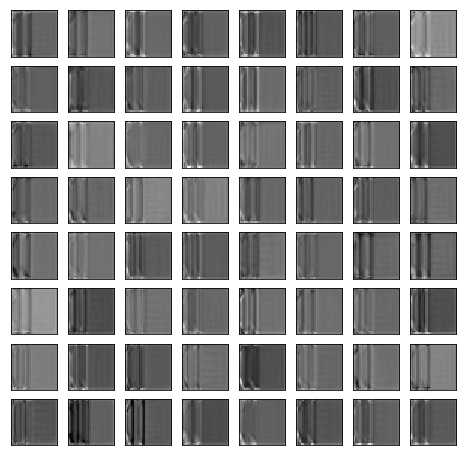

In [96]:
print_activations('lstm.3.conv_h')

torch.Size([192, 31, 31])


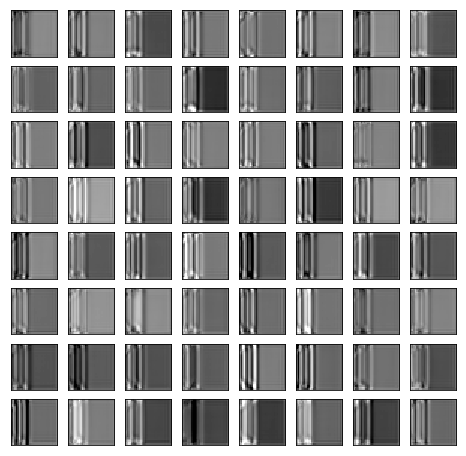

In [97]:
print_activations('lstm.0.conv_c')

torch.Size([192, 31, 31])


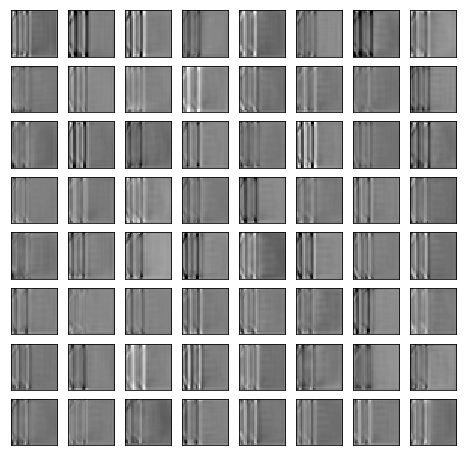

In [98]:
print_activations('lstm.0.conv_m')

torch.Size([448, 31, 31])


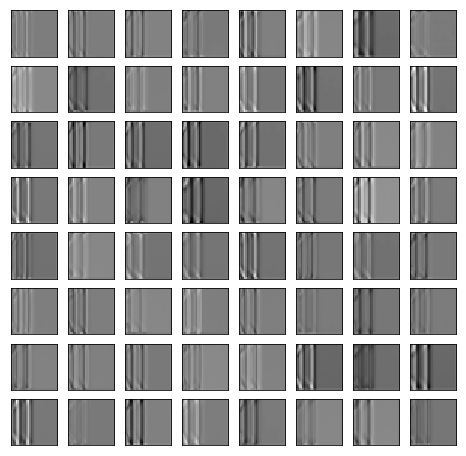

In [99]:
print_activations('lstm.0.conv_x')

torch.Size([64, 31, 31])


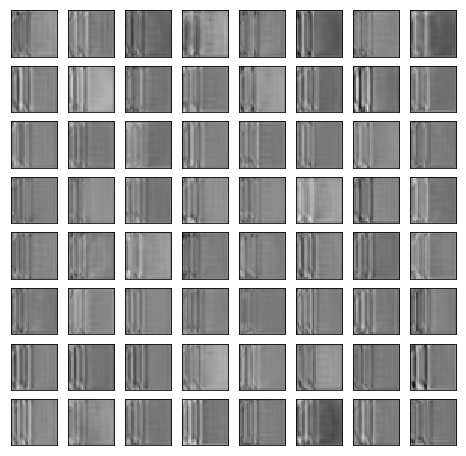

In [100]:
print_activations('lstm.0.conv_o')